## Aim

Compute an ABC occurrence rate estimate, and compare results with ```occurrence_mcmc```.

In [1]:
import sys
sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from dev.abc import ABCSampler
from dev import price_rogers_2014_binned, dataprocessing, completeness
from tqdm.notebook import tqdm
from scipy.stats import gamma
from functools import partial
import warnings
# warnings.simplefilter('error', RuntimeWarning)

%load_ext autoreload
%autoreload 2

In [2]:
# a _very_ common debugging utility
def minmeanmax(statistic, name):
    print("{0} min-mean-max-hasnan".format(name), min(statistic), np.nanmean(statistic), max(statistic), any(np.isnan(statistic)))

My ABC setup requires

- a prior occurrence estimate.
- a candidate generator for the model parameters $\theta$, i.e. a ```stats.continuous_rv/stats.discrete_rv``` object whose .rvs() method returns candidate parameters.
- a sampler for $f(x \mid \theta)$
- distance and statistic functions
- data to fit

In [3]:
kois = dataprocessing.get_kois()
stellar = dataprocessing.get_stellar()
kois = kois[kois["kepid"].isin(stellar["kepid"])]
kois = kois[np.isfinite(kois["koi_prad"])]
stellar = stellar[np.isfinite(stellar.mass)]

In [4]:
period_bins = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp_bins = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
log_p, log_r = np.log(period_bins), np.log(rp_bins)
log_p = np.append(log_p, np.log(640))
log_r = np.append(log_r, np.log(20))
period_rng = (min(period_bins), max(period_bins))
rp_rng = (min(rp_bins), max(rp_bins))

f = np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0] / len(stellar)
lam = np.sum(f)
lam

0.02641651566667345

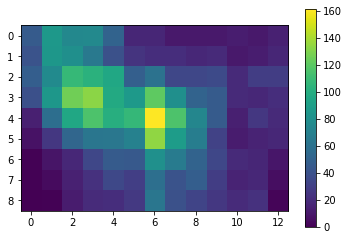

In [5]:
plt.imshow(np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0])
plt.colorbar()

In [6]:
cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

def pcomp_vectors(stars, periods, rp, eccs, cosincls):
    '''
    Self-contained, returns pcomp over matched arrays of planets around stars.
    '''
    c = 1.0874
    s = 1.0187
    Go4pi = 2945.4625385377644/(4*np.pi*np.pi)
    re = 0.009171
    
    mstars = stars['mass'].values
    rstars = stars['radius'].values
    cdpp = np.array(stars[cdpp_cols], dtype=float)
    dataspan = stars['dataspan'].values
    dataspan = np.nan_to_num(dataspan)
    dutycycle = stars['dutycycle'].values
    dutycycle = np.nan_to_num(dutycycle)
    mesthres_cols_stars = np.array(stars[mesthres_cols], dtype=float)
    
    aor = (Go4pi*periods*periods*mstars) ** (1./3) / rstars
    tau = 6 * periods * np.sqrt(1 - eccs**2) / aor

    sigma = np.array([np.interp(tau[i], cdpp_vals, cdpp[i]) for i in range(len(tau))])
    sigma = np.nan_to_num(sigma, nan=1)
    # Compute the radius ratio and estimate the S/N.

    k = rp * re / rstars
    delta = 0.84 * k*k * (c + s*k)
    snr = delta * 1e6 / sigma

    # Scale by the estimated number of transits.
    ntrn = dataspan * dutycycle / periods
    mess = snr * np.sqrt(ntrn)
    
    mest = np.array([np.interp(tau[i], mesthres_vals, mesthres_cols_stars[i]) for i in range(len(tau))])
    mest = np.nan_to_num(mest, nan=7.1)
    x = mess - 4.1 - (mest - 7.1)
    pdets = pgam.cdf(x)
    
    M = dataspan / periods
    f = dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) & (M >= 2.0)
    pwins = pw * msk
    # pwins = np.nan_to_num(pwins)
    
    pgeom = aor * cosincls * (1 - eccs * eccs) <= 1 # for now, assume sin omega = 0
    # pgeom = 1. / (aor * (1 - eccs*eccs)) * (aor > 1.0)
    
    pgeom = np.nan_to_num(pgeom)
    
    '''try:
        assert np.all(pdets >= 0) and np.all(pdets <= 1), "pdets are out of range"
        assert np.all(pwins >= 0) and np.all(pwins <= 1), "pwins are out of range"
        assert np.all(pgeom >= 0) and np.all(pgeom <= 1), "pgeom are out of range"
    except AssertionError as e:
        for p in [pdets, pwins, pgeom]:
            minmeanmax(p, "probs in order det, win, geo")
        raise'''
    return pdets * pwins * pgeom

Text(0.5, 1.0, 'pcomps')

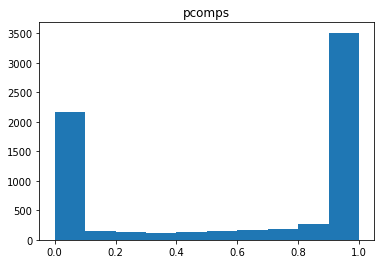

In [7]:
combined = pd.merge(kois, stellar, on='kepid')
pcomp = partial(completeness.get_completeness, pgam=pgam, mesthres_cols=mesthres_cols, mesthres_vals=mesthres_vals)
cosincls = np.cos(np.pi * combined['koi_incl'] / 180)
pcomps = pcomp_vectors(combined, combined['koi_period'], combined['koi_prad'], combined['koi_eccen'], cosincls)
plt.hist(pcomps[~np.isnan(pcomps)])
plt.title("pcomps")

In [8]:
num_stars = len(stellar)
stellar_sample = stellar.sample(n=num_stars)

(array([1256.,  938.,  714.,  559.,  452.,  451.,  433.,  371.,  345.,
         512.]),
 array([0.     , 0.09992, 0.19984, 0.29976, 0.39968, 0.4996 , 0.59952,
        0.69944, 0.79936, 0.89928, 0.9992 ]),
 <a list of 10 Patch objects>)

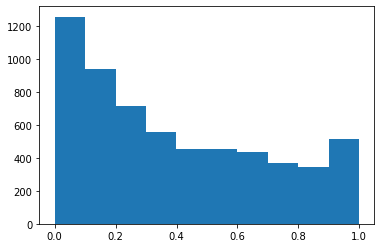

In [9]:
plt.hist(combined.koi_impact[combined.koi_impact < 1])

In [10]:
t0_range = (min(kois.koi_time0), max(kois.koi_time0))

def add_uncertainties(price_uncertainty_params):
    '''
    Adds uncertainties to parameters based on Price and Rogers (2014).
    
    Arguments
    ---------
    price_uncertainty_parameters : list of scalars / numpy.ndarrays.
    The parameters in the signature from each of the Price/Rogers variance functions.
    (delta, T, tau, f0, texp, Ttot, gamma, sigma).
    delta - transit depth
    T - full-width at half-max transit time
    tau - duration of ingress and egress
    f0 - starting flux, which we set to 1.
    texp - time of exposure, about 30 minutes for Kepler.
    Ttot -  same as P in this case, I think
    gamma - sampling rate
    sigma - model uncertainty
    
    Returns
    -------
    perturbed_parameters : list of scalars / numpy.ndarrays.
    The same list, but with white noise added.
    '''
    var_d = abs(np.vectorize(price_rogers_2014_binned.prVarDelta)(*price_uncertainty_params)) * 0 # abs is stopgap
    noise = np.random.normal(0, np.sqrt(var_d), size=(len(price_uncertainty_params[0]),))
    noise = np.nan_to_num(noise)
    price_uncertainty_params[0] += noise
    return price_uncertainty_params

def generate_planet_catalog(f, stars):
    '''
    Takes in the occurrence rate matrix f and generates `num_planets' planets, 
    represented as a matrix of state (row) vectors.
    
    Each row has: period in days; radius in Earth radii; eccentricity; cosine of inclination; impact parameter;
    time of first transit in BJD; fractional transit depth; transit duration in days; is_detected (bool).
    
    Arguments
    ---------
    f : np.ndarray
    f = f(r, p); occurrence rate prior that we sample p and r from.
    
    stars : pd.dataframe
    A sample of the stellar dataframe.
    '''
    re = 0.009171
    planet_params = ['kepid', 'period', 'prad', 'ecc', 'cosincl', 'b', 't0', 'd', 'D']
    lam = np.sum(f)
    nums_planets = np.minimum(stats.poisson(lam).rvs((len(stars),)), 10)
    num_planets = sum(nums_planets)
    stellar_catalog = pd.DataFrame(np.repeat(stars.values, nums_planets, axis=0))
    stellar_catalog.columns = stars.columns
    stellar_catalog = stellar_catalog.astype(stars.dtypes)
    flat_f = f.flatten()
    buckets = np.random.choice(f.size, p = flat_f / lam, size=(num_planets,))
    p_left_inds = buckets // f.shape[1]
    p_right_inds = p_left_inds + 1
    r_left_inds = buckets % f.shape[1]
    r_right_inds = r_left_inds + 1
    periods = np.exp(np.random.uniform(log_p[p_left_inds], log_p[p_right_inds]))
    pl_rads = np.exp(np.random.uniform(log_r[r_left_inds], log_r[r_right_inds]))
    eccens  = stats.rayleigh(scale=0.03).rvs(size=(num_planets,))
    cosincl = np.random.uniform(0, 1, size=(num_planets,))
    impacts = np.random.uniform(0, 1, size=(num_planets,))
    t0 = np.random.uniform(*t0_range, size=(num_planets,))
    ror = pl_rads * re / stellar_catalog.radius.values
    depths = ror ** 2 # these are all not nan
    aor = completeness.get_a(periods, stellar_catalog.mass.values) / stellar_catalog.radius.values
    arcsin_args = np.sqrt((1 + ror) ** 2 - impacts ** 2) / aor
    problems = np.where(arcsin_args > 1)[0]
    impacts[problems] = np.minimum(1, np.sqrt((1 + ror[problems]) ** 2 - (aor[problems]) ** 2))
    # some impacts are 1 + eps
    arcsin_args[problems] = 1
    D = (periods / np.pi) * np.arcsin(arcsin_args)
    tau0 = periods * impacts / (2 * np.pi * cosincl * np.sqrt(1 - eccens ** 2)) * 1 / (aor ** 2)
    T = 2 * tau0 * np.sqrt(1 - impacts ** 2)
    tau = 2 * tau0 * np.divide(ror, np.sqrt(1 - impacts ** 2), where = impacts != 1)
    f0 = 1
    texp = 1765.5 / 60 / 60 / 24 # s to days
    gamma = 1 / texp # inverse s to inverse days
    sigma = 1 # 'model uncertainty'
    
    price_uncertainty_params = [depths, T, tau, f0, texp, periods, gamma, sigma]
    price_uncertainty_params = add_uncertainties(price_uncertainty_params)
    
    depths = price_uncertainty_params[0]

    pl_rads = np.sqrt(depths) * stellar_catalog.radius / re
    periods = price_uncertainty_params[5]
    # [kepid, period, radius, ecc, cosincl, impact param b, t0, transit depth d, transit duration D, is_detected]
    planets_matrix = np.vstack((stellar_catalog.kepid, periods, pl_rads, eccens, cosincl, impacts, t0, depths, D)).T
    planetary_catalog = pd.DataFrame(planets_matrix, columns=planet_params)
    probs = pcomp_vectors(stellar_catalog, periods, pl_rads, eccens, cosincl)
    probs = np.array(probs)
    probs = np.nan_to_num(probs)
    if np.allclose(probs, 0):
        print("all probabilities of detection are 0")
    detected = np.random.binomial(1, np.nan_to_num(probs))
    planetary_catalog['is_detected'] = detected
    return stellar_catalog, planetary_catalog.astype({'kepid': np.int64, 'is_detected': bool})

In [11]:
st, pl = generate_planet_catalog(f, stellar_sample)
if len(stellar_sample) == len(stellar):
    pl.to_csv('../data/catalog_synth.csv')

In [12]:
sum(pl.is_detected)

308

In [13]:
detected_planets = pl[pl.is_detected]

(array([62., 66., 45., 47., 49., 17., 14.,  5.,  2.,  1.]),
 array([-0.69174582, -0.08228168,  0.52718245,  1.13664659,  1.74611072,
         2.35557486,  2.965039  ,  3.57450313,  4.18396727,  4.7934314 ,
         5.40289554]),
 <a list of 10 Patch objects>)

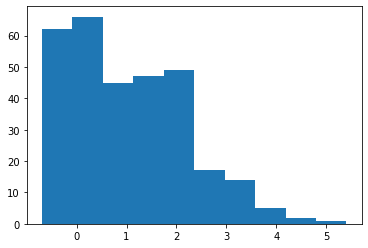

In [14]:
plt.hist(np.log(detected_planets.period))

(array([22., 62., 80., 53., 30., 18.,  8., 11., 10., 14.]),
 array([-0.32173203, -0.01305862,  0.2956148 ,  0.60428821,  0.91296163,
         1.22163504,  1.53030846,  1.83898187,  2.14765529,  2.4563287 ,
         2.76500212]),
 <a list of 10 Patch objects>)

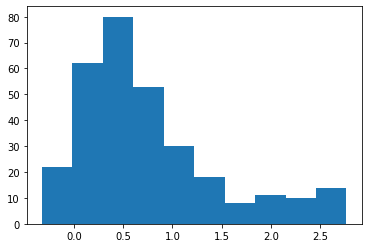

In [15]:
plt.hist(np.log(detected_planets.prad))

In [16]:
N = np.zeros_like(f)
detected = pl[pl.is_detected]
period_inds = np.digitize(np.log(detected.period), log_p)
radius_inds = np.digitize(np.log(detected.prad), log_r)
for i, j in zip(period_inds, radius_inds):
    if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
        N[i][j] += 1
        
N /= len(stellar_sample)

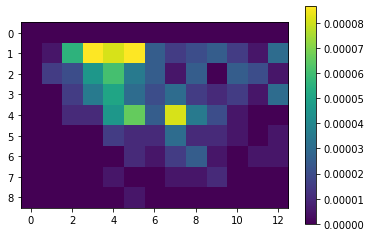

In [17]:
plt.imshow(N)
plt.colorbar()

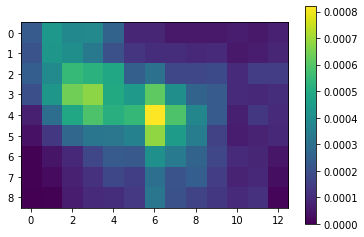

In [19]:
sample_N = np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0] / len(stellar)
plt.imshow(sample_N)
plt.colorbar()

In [20]:
# %timeit generate_planet_catalog(f, stellar)
# 12.4 s ± 2.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [21]:
diff = N - sample_N
statistic = np.sum(diff ** 2)
statistic

8.735721215019108e-06

In [22]:
stellar_catalog_abc = pd.DataFrame(np.vstack([stellar[stellar.kepid == k].to_numpy() for k in kois.kepid]))
stellar_catalog_abc.columns = stellar.columns
stellar_catalog_abc = stellar_catalog_abc.astype(stellar.dtypes)

In [29]:
stellar_sample_size = len(stellar)
stellar_sample = stellar.sample(n=stellar_sample_size)

class SyntheticCatalog:
    def __init__(self, f, stars, planets=None):
        self.f = f
        if planets is None:
            self.stars, self.planets = generate_planet_catalog(f, stars)
        else:
            self.planets = planets
            self.stars = stars

class OccurrencePrior(stats.rv_continuous):
    def pdf(self, f):
        return np.prod(np.exp(-f))
    
    def rvs(self):
        return stats.expon.rvs(size=(len(period_bins) * len(rp_bins),))
    
def occurrence_candidate_getter(f):
    def candidate(size=1):
        return [SyntheticCatalog(f.reshape(len(period_bins), len(rp_bins)), stellar_sample) for _ in range(size)]
    return candidate
    
def occurrence_distance(s1, s2):
    return np.sum((s1 - s2) ** 2)

def occurrence_statistic(catalogs):
    Nstars = 0
    N = np.zeros((len(log_p) - 1, len(log_r) - 1))
    for catalog in catalogs:
        Nstars += len(catalog.stars)
        detected = catalog.planets[catalog.planets.is_detected]
        period_bins = np.digitize(np.log(detected.period.values), log_p)
        radius_bins = np.digitize(np.log(detected.prad.values), log_r)
        for i, j in zip(period_bins, radius_bins):
            if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
                N[i][j] += 1
    return N / Nstars
    
OccurrenceABCSampler = ABCSampler(OccurrencePrior(), occurrence_candidate_getter, occurrence_distance, occurrence_statistic)

In [30]:
kois_catalog_abc = kois.rename(columns={'koi_period': 'period', 'koi_prad': 'prad'})
kois_catalog_abc["is_detected"] = kois_catalog_abc["koi_disposition"] == "CONFIRMED"
kois_abc = [SyntheticCatalog(f, stellar_catalog_abc, kois_catalog_abc)]

In [31]:
abc_f = OccurrenceABCSampler.sample(kois_abc, threshold=2e-3, verbose=True)

0.002164461855409175
0.0021496774393643353
0.0020628739672973006
0.0021442626183139717
0.002027253619561481


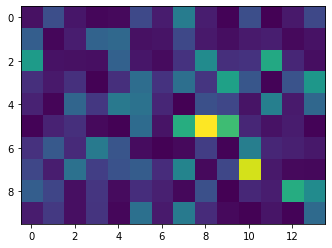

In [33]:
plt.imshow(abc_f.reshape((len(period_bins), len(rp_bins))))

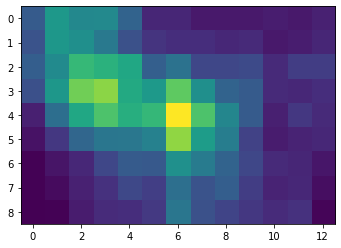

In [34]:
plt.imshow(f)

impact parameter > 1: either a FP, or on the edge of the star. The transiting object has to be big, and often that's actually a star.

In [ ]:
# Do not run till this is rewritten to be vectorized
abc_pmc_f = OccurrenceABCSampler.sample_pmc(kois_abc, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 2)